# Project 1
Our project is to uncover the relationship between gold and crypto currencies. Based on the historical relation of gold and inflation, how does gold compare to Bitcoin, Ethereum, Miners, and Fantom coin (FTM) against inflation now. How can we make an educated decision on where to make initial cash investment? In gold or crypto?

In [115]:
import plotly.express as px
import panel as pn
import pandas as pd
import quandl
import os
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime as dt
import numpy as np

import hvplot.pandas
import plotly.express as px

%matplotlib inline

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:


* `LBMA-GOLD.csv`: Contains historical closing prices of gold???

* `bitcoin-price-history.csv`: ontains historical open, high, low, close, volume, and market cap of Bitcoin.

* `ethereum-price-history.csv`: Contains historical open, high, low, close, volume, and market cap of Etherium.

* `dxy-price-history.csv`: ontains historical copen, high, low, close, adj close, and volume of the dollar index




## Pulling Inflation Data from Quandl API

In [112]:
inflation_projection = quandl.get("FRED/PCECTPIMD")
inflation_projection

,Value
Date,
2021-01-01,3.4
2022-01-01,2.1
2023-01-01,2.2


In [113]:
inflation_projection_plot = inflation_projection.hvplot.line()
inflation_projection_plot

:Curve   [Date]   (Value)

In [114]:
inflation_hist_df = quandl.get("RATEINF/CPI_USA")
inflation_hist_df

,Value
Date,
1913-01-31,9.800
1913-02-28,9.800
1913-03-31,9.800
1913-04-30,9.800
1913-05-31,9.700
...,...
2021-02-28,263.014
2021-03-31,264.877
2021-04-30,267.054


In [67]:
#dxy_var_hist_df = dxy_hist_df['Close'].var()
#dxy_var_hist_df
inflation_hist_df = inflation_hist_df[['Value']]
inflation_hist_pct_df = inflation_hist_df.pct_change()
inflation_hist_pct_df.dropna(inplace=True)
inflation_hist_pct_df

,Value
Date,
1913-02-28,0.000000
1913-03-31,0.000000
1913-04-30,0.000000
1913-05-31,-0.010204
1913-06-30,0.010309
...,...
2021-02-28,0.005474
2021-03-31,0.007083
2021-04-30,0.008219


In [68]:
# Rename the column
inflation_hist_pct_df.rename(columns = {"Value": "Inflation Rate"}, inplace = True)
inflation_hist_pct_df

,Inflation Rate
Date,
1913-02-28,0.000000
1913-03-31,0.000000
1913-04-30,0.000000
1913-05-31,-0.010204
1913-06-30,0.010309
...,...
2021-02-28,0.005474
2021-03-31,0.007083
2021-04-30,0.008219


In [69]:
cumulative_returns = (1 + inflation_hist_pct_df).cumprod() - 1
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Inflation Rate)

In [70]:
# import DXY history data to Pandas
df_daily_mc_path = Path("df_daily_mc.csv")
df_daily_mc_df = pd.read_csv(dxy_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
df_daily_mc_df.index = pd.to_datetime(df_daily_mc_df.index)

In [71]:
# import DXY history data to Pandas
dxy_hist_path = Path("./Resources/dxy-price-history.csv")
dxy_hist_df = pd.read_csv(dxy_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
dxy_hist_df.index = pd.to_datetime(dxy_hist_df.index)

In [72]:
# import tether history data to Pandas
tether_hist_path = Path("./Resources/tether-price-history.csv")
tether_hist_df = pd.read_csv(tether_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
tether_hist_df.index = pd.to_datetime(tether_hist_df.index)

In [119]:
#import bitcoin daily history data to Pandas
btc_hist_path = Path("./Resources/bitcoin-price-history.csv")

btc_hist_df = pd.read_csv(btc_hist_path, index_col="Date",infer_datetime_format=True, parse_dates=True)
#btc_hist_df["Date"]=btc_hist_df["Date"].astype("datetime")
#btc_hist_df.dtypes
btc_hist_df.index = pd.to_datetime(btc_hist_df.index)
#btc_hist_df.set_index(pd.to_datetime(btc_hist_df.index))
btc_hist_df.sort_index(inplace=True)
btc_hist_df.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-07-17,96.7100,99.9700,96.1800,98.5000,0.0,1.120160e+09
2013-07-18,98.5000,98.8000,86.2000,90.5800,0.0,1.050191e+09
2013-07-19,90.0689,95.2001,87.8000,92.1700,0.0,1.035626e+09
2013-07-20,92.0000,93.1000,89.2711,89.3901,0.0,1.051175e+09
2013-07-21,89.8214,91.9500,88.0000,90.7573,0.0,1.025637e+09


In [74]:
#import bitcoin montly history data to Pandas
btc_hist_monthly_path = Path("bitcoin_2016-8-2_2021-8-1.csv") 

btc_hist_monthly_df = pd.read_csv(btc_hist_path, index_col="Date",infer_datetime_format=True, parse_dates=True)
#btc_hist_df["Date"]=btc_hist_df["Date"].astype("datetime")
#btc_hist_df.dtypes
btc_hist_monthly_df.index = pd.to_datetime(btc_hist_monthly_df.index)
#btc_hist_df.set_index(pd.to_datetime(btc_hist_df.index))

In [75]:
# import eth daily history data to Pandas
eth_hist_path = Path("./Resources/ethereum-price-history.csv")
eth_hist_df = pd.read_csv(eth_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
eth_hist_df.index = pd.to_datetime(eth_hist_df.index)

In [76]:
# import eth monthly history data to Pandas
eth_hist_monthly_path = Path("./Resources/ethereum-price-history.csv")
eth_hist_monthly_df = pd.read_csv(eth_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
eth_hist_monthly_df.index = pd.to_datetime(eth_hist_monthly_df.index)

In [77]:
# import gld history data to Pandas
gld_hist_path = Path("./Resources/LBMA-GOLD.csv")
gld_hist_df = pd.read_csv(gld_hist_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
gld_hist_df.index = pd.to_datetime(gld_hist_df.index)

## Dollar Index Data

Read the Dollar Index historic closing prices and create a new daily returns DataFrame from the data. 

In [78]:
#dxy_var_hist_df = dxy_hist_df['Close'].var()
#dxy_var_hist_df
dxy_hist_close_df = dxy_hist_df[['Close']]
dxy_hist_pct_df = dxy_hist_close_df.pct_change()
dxy_hist_pct_df.dropna(inplace=True)
dxy_hist_pct_df

,Close
Date,
1971-08-25,0.000000
1971-08-26,0.000000
1971-08-27,0.000000
1971-08-29,0.000000
1971-08-30,0.000000
...,...
2021-07-19,0.002158
2021-07-20,0.000861
2021-07-21,-0.002366


In [79]:
# Rename the column
dxy_hist_pct_df.rename(columns = {"Close": "DXY"}, inplace = True)
dxy_hist_pct_df

,DXY
Date,
1971-08-25,0.000000
1971-08-26,0.000000
1971-08-27,0.000000
1971-08-29,0.000000
1971-08-30,0.000000
...,...
2021-07-19,0.002158
2021-07-20,0.000861
2021-07-21,-0.002366


In [80]:
cumulative_returns = (1 + dxy_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (DXY)

## Tether Data

In [81]:
#tether_var_hist_df = tether_hist_df['Close'].var()
#tether_var_hist_df
tether_hist_close_df = tether_hist_df[['Close']]
tether_hist_pct_df = tether_hist_close_df.pct_change()
tether_hist_pct_df.dropna(inplace=True)
tether_hist_pct_df

,Close
Date,
2017-08-30,-0.000779
2017-08-31,0.002378
2017-09-01,0.001246
2017-09-02,0.013451
2017-09-03,-0.015375
...,...
2021-07-24,-0.000300
2021-07-25,0.000000
2021-07-26,0.000000


In [82]:
# Rename the column
tether_hist_pct_df.rename(columns = {"Close": "Tether"}, inplace = True)
tether_hist_pct_df

,Tether
Date,
2017-08-30,-0.000779
2017-08-31,0.002378
2017-09-01,0.001246
2017-09-02,0.013451
2017-09-03,-0.015375
...,...
2021-07-24,-0.000300
2021-07-25,0.000000
2021-07-26,0.000000


In [83]:
cumulative_returns = (1 + tether_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Tether)

## Bitcoin Returns

Read the Bitcoin historic closing prices and create a new daily returns DataFrame from the data.

In [84]:
#btc_var_hist_df = btc_hist_df['Close'].var()
#btc_var_hist_df
btc_hist_close_df = btc_hist_df[['Close']]
btc_hist_pct_df = btc_hist_close_df.pct_change()
btc_hist_pct_df.dropna(inplace=True)

In [85]:
# Rename the column
btc_hist_pct_df.rename(columns = {"Close": "BTC"}, inplace = True)
btc_hist_pct_df

,BTC
Date,
2021-07-22,-0.034846
2021-07-21,-0.006049
2021-07-20,-0.074138
2021-07-19,0.036694
2021-07-18,0.031150
...,...
2013-07-21,-0.009308
2013-07-20,-0.015064
2013-07-19,0.031099


In [86]:
#btc_var_hist_df = btc_hist_df['Close'].var()
#btc_var_hist_df
btc_hist_monthly_close_df = btc_hist_monthly_df[['Close']]
btc_hist_monthly_pct_df = btc_hist_monthly_close_df.pct_change()
btc_hist_monthly_pct_df.dropna(inplace=True)

In [87]:
# Rename the column
btc_hist_monthly_pct_df.rename(columns = {"Close": "BTC"}, inplace = True)
btc_hist_monthly_pct_df

,BTC
Date,
2021-07-22,-0.034846
2021-07-21,-0.006049
2021-07-20,-0.074138
2021-07-19,0.036694
2021-07-18,0.031150
...,...
2013-07-21,-0.009308
2013-07-20,-0.015064
2013-07-19,0.031099


In [88]:
cumulative_returns = (1 + btc_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (BTC)

## Ethereum Returns

Read the Ethereum historic closing prices and create a new daily returns DataFrame from the data. 

In [89]:
#eth_var_hist_df = eth_hist_df['Close'].var()
#eth_var_hist_df
eth_hist_close_df = eth_hist_df[['Close']]
eth_hist_pct_df = eth_hist_close_df.pct_change()
eth_hist_pct_df.dropna(inplace=True)

In [90]:
# Rename the column
eth_hist_pct_df.rename(columns = {"Close": "ETH"}, inplace = True)
eth_hist_pct_df

,ETH
Date,
2016-07-26,-0.148242
2016-07-27,0.102132
2016-07-28,-0.007922
2016-07-29,-0.003553
2016-07-30,-0.026506
...,...
2021-07-19,-0.040577
2021-07-20,-0.020670
2021-07-21,0.116298


In [91]:
#eth_var_hist_df = eth_hist_df['Close'].var()
#eth_var_hist_df
eth_hist_monthly_close_df = eth_hist_monthly_df[['Close']]
eth_hist_monthly_pct_df = eth_hist_monthly_close_df.pct_change()
eth_hist_monthly_pct_df.dropna(inplace=True)

In [92]:
# Rename the column
eth_hist_monthly_pct_df.rename(columns = {"Close": "ETH"}, inplace = True)
eth_hist_monthly_pct_df

,ETH
Date,
2016-07-26,-0.148242
2016-07-27,0.102132
2016-07-28,-0.007922
2016-07-29,-0.003553
2016-07-30,-0.026506
...,...
2021-07-19,-0.040577
2021-07-20,-0.020670
2021-07-21,0.116298


In [93]:
cumulative_returns = (1 + eth_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (ETH)

## Gold Returns

Read the Gold historic closing prices and create a new daily returns DataFrame from the data.

In [94]:
#gld_var_hist_df = gld_hist_df['Close'].var()
#gld_var_hist_df
gld_hist_df = gld_hist_df[['USD (PM)']]
gld_hist_pct_df = gld_hist_df.pct_change()
gld_hist_pct_df.dropna(inplace=True)
gld_hist_pct_df

,USD (PM)
Date,
2021-06-29,-0.004367
2021-06-28,0.014156
2021-06-25,0.003567
2021-06-24,-0.001007
2021-06-23,0.003782
...,...
1968-01-08,0.000000
1968-01-05,0.000000
1968-01-04,0.000000


In [95]:
# Rename the column
gld_hist_pct_df.rename(columns = {"USD (PM)": "Gold"}, inplace = True)
gld_hist_pct_df

,Gold
Date,
2021-06-29,-0.004367
2021-06-28,0.014156
2021-06-25,0.003567
2021-06-24,-0.001007
2021-06-23,0.003782
...,...
1968-01-08,0.000000
1968-01-05,0.000000
1968-01-04,0.000000


In [96]:
cumulative_returns = (1 + gld_hist_pct_df).cumprod()
cumulative_returns_plot = cumulative_returns.hvplot.line()
cumulative_returns_plot

:Curve   [Date]   (Gold)

## Combine Returns 

In [97]:
# Concatenate btc and dxy dataframes into one dataframe
df_daily_btc_dxy = pd.concat([btc_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_btc_dxy

,BTC,DXY
Date,,
2021-07-22,-0.034846,0.000755
2021-07-21,-0.006049,-0.002366
2021-07-20,-0.074138,0.000861
2021-07-19,0.036694,0.002158
2021-07-18,0.031150,0.000000
...,...,...
2013-07-22,-0.041320,-0.004359
2013-07-21,-0.009308,0.000000
2013-07-19,0.031099,-0.002898


In [98]:
# Concatenate btc and eth dataframes into one dataframe
df_daily_btc_eth = pd.concat([btc_hist_pct_df, eth_hist_pct_df], axis = "columns", join = "inner")
df_daily_btc_eth

,BTC,ETH
Date,,
2021-07-22,-0.034846,0.017032
2021-07-21,-0.006049,0.116298
2021-07-20,-0.074138,-0.020670
2021-07-19,0.036694,-0.040577
2021-07-18,0.031150,0.000300
...,...,...
2016-07-30,0.048031,-0.026506
2016-07-29,0.002867,-0.003553
2016-07-28,-0.002777,-0.007922


In [100]:
# Concatenate btc and eth dataframes into one dataframe
df_monthly_btc_eth = pd.concat([btc_hist_monthly_pct_df, eth_hist_monthly_pct_df], axis = "columns", join = "inner")
df_monthly_btc_eth

,BTC,ETH
Date,,
2021-07-22,-0.034846,0.017032
2021-07-21,-0.006049,0.116298
2021-07-20,-0.074138,-0.020670
2021-07-19,0.036694,-0.040577
2021-07-18,0.031150,0.000300
...,...,...
2016-07-30,0.048031,-0.026506
2016-07-29,0.002867,-0.003553
2016-07-28,-0.002777,-0.007922


In [101]:
# Concatenate eth and dxy dataframes into one dataframe
df_daily_eth_dxy = pd.concat([eth_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_eth_dxy

,ETH,DXY
Date,,
2016-07-26,-0.148242,-0.001336
2016-07-27,0.102132,-0.001132
2016-07-28,-0.007922,-0.003194
2016-07-29,-0.003553,-0.012508
2016-07-31,-0.048772,0.000000
...,...,...
2021-07-19,-0.040577,0.002158
2021-07-20,-0.020670,0.000861
2021-07-21,0.116298,-0.002366


In [102]:
# Concatenate gold and dxy dataframes into one dataframe
df_daily_gold_dxy = pd.concat([gld_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily_gold_dxy

,Gold,DXY
Date,,
2021-06-29,-0.004367,0.001850
2021-06-28,0.014156,0.000762
2021-06-25,0.003567,-0.000109
2021-06-24,-0.001007,0.000218
2021-06-23,0.003782,0.000763
...,...,...
1971-09-01,-0.006767,0.000944
1971-08-31,-0.010949,-0.011626
1971-08-27,0.011562,0.000000


In [103]:
# Concatenate all dataframes into one dataframe
df_daily = pd.concat([btc_hist_pct_df, eth_hist_pct_df, gld_hist_pct_df, tether_hist_pct_df, dxy_hist_pct_df], axis = "columns", join = "inner")
df_daily

,BTC,ETH,Gold,Tether,DXY
Date,,,,,
2021-06-29,0.022246,0.039348,-0.004367,0.000100,0.001850
2021-06-28,-0.039097,0.056421,0.014156,0.000000,0.000762
2021-06-25,-0.004711,-0.083234,0.003567,-0.000153,-0.000109
2021-06-24,0.090570,0.008622,-0.001007,0.000067,0.000218
2021-06-23,-0.027015,0.053456,0.003782,0.000000,0.000763
...,...,...,...,...,...
2017-09-06,-0.002094,0.066569,-0.004205,0.000856,-0.000217
2017-09-05,-0.045468,0.060779,-0.001719,-0.025540,-0.005387
2017-09-01,0.068183,0.011736,-0.009527,0.001246,0.001511


# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

<AxesSubplot:xlabel='Date'>

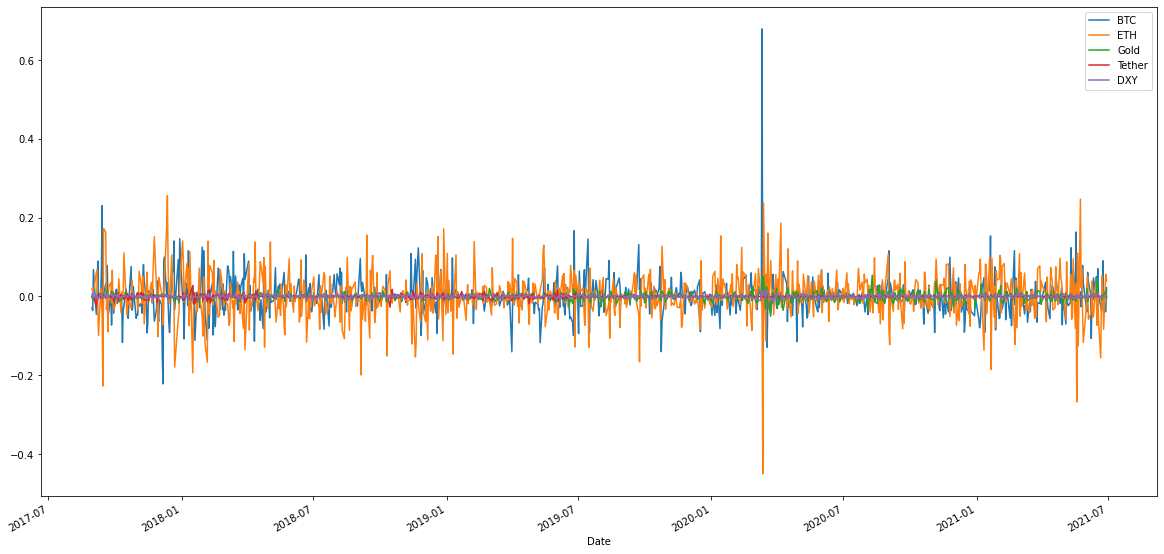

In [104]:
# Plot daily returns
df_daily.plot(figsize = (20,10))

<AxesSubplot:>

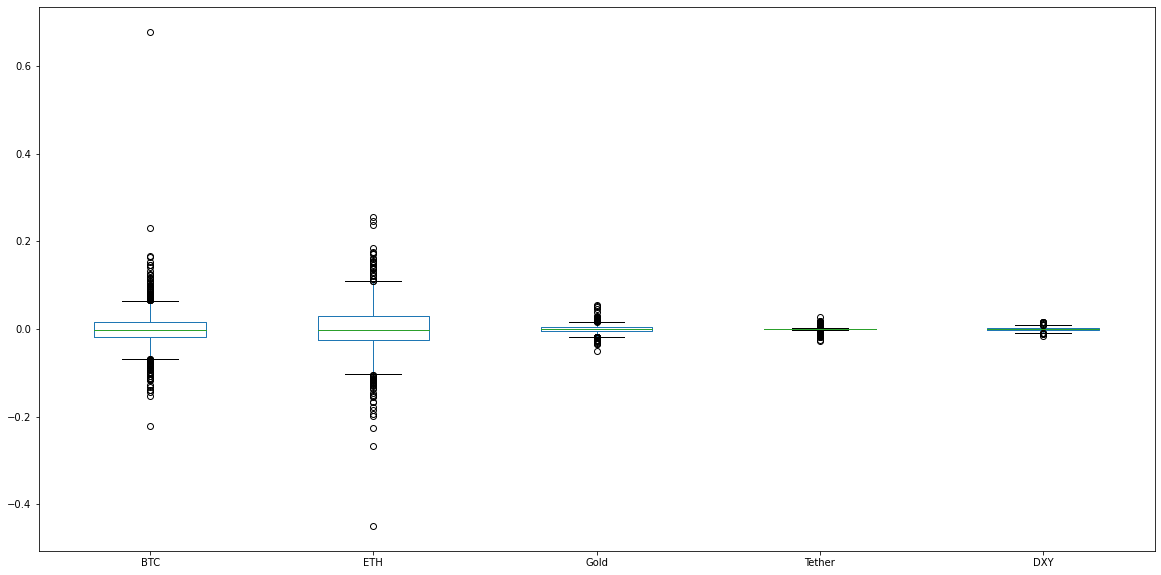

In [105]:
# Box plot to visually illustrate risk
df_daily.plot(kind = "box", figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

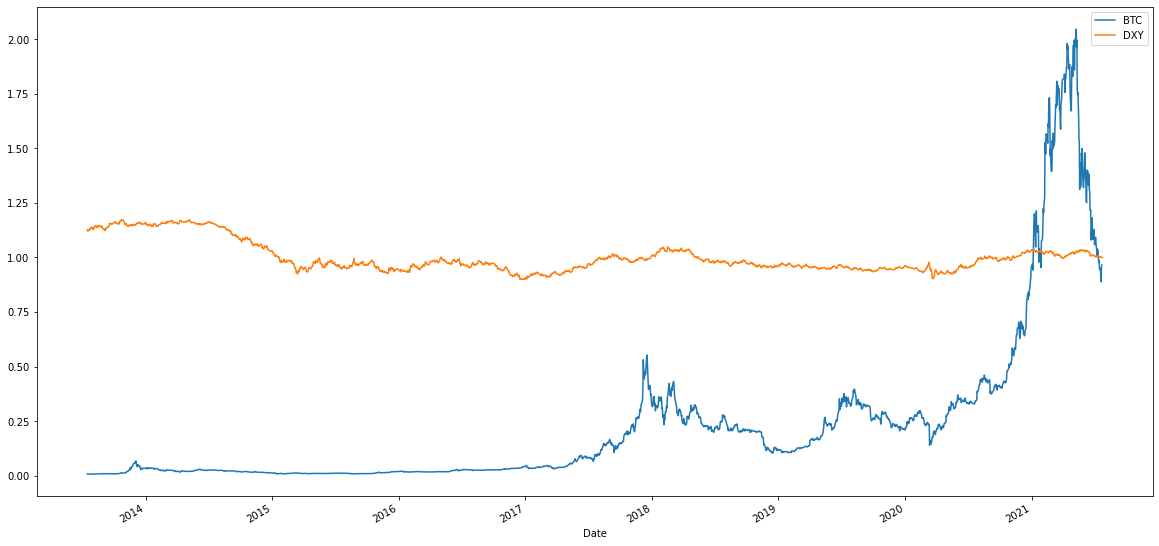

In [108]:
# Plot cumulative returns of btc compared to dxy
df_cum = (1 + df_daily_btc_dxy).cumprod()
df_cum.plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

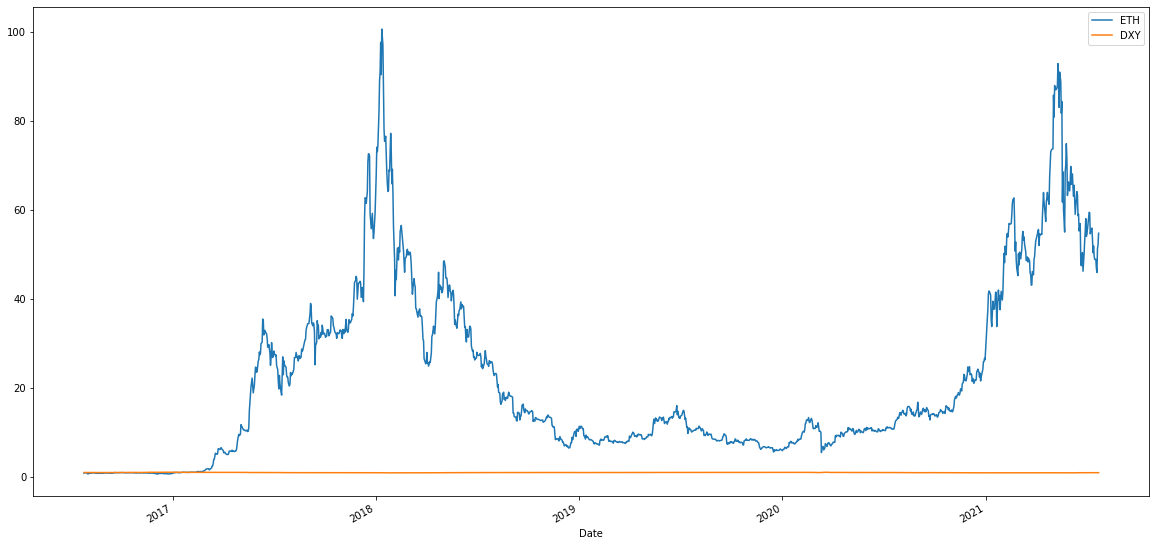

In [109]:
# Plot cumulative returns of eth compared to dxy
df_cum = (1 + df_daily_eth_dxy).cumprod()
df_cum.plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

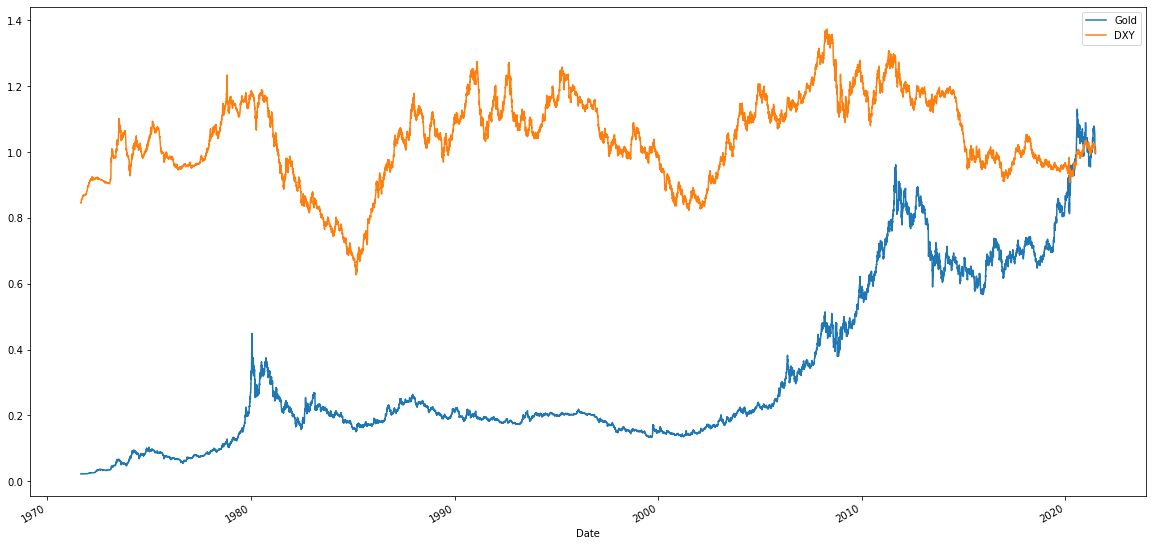

In [491]:
# Plot cumulative returns of gld compared to dxy
df_cum = (1 + df_daily_gold_dxy).cumprod()
df_cum.plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

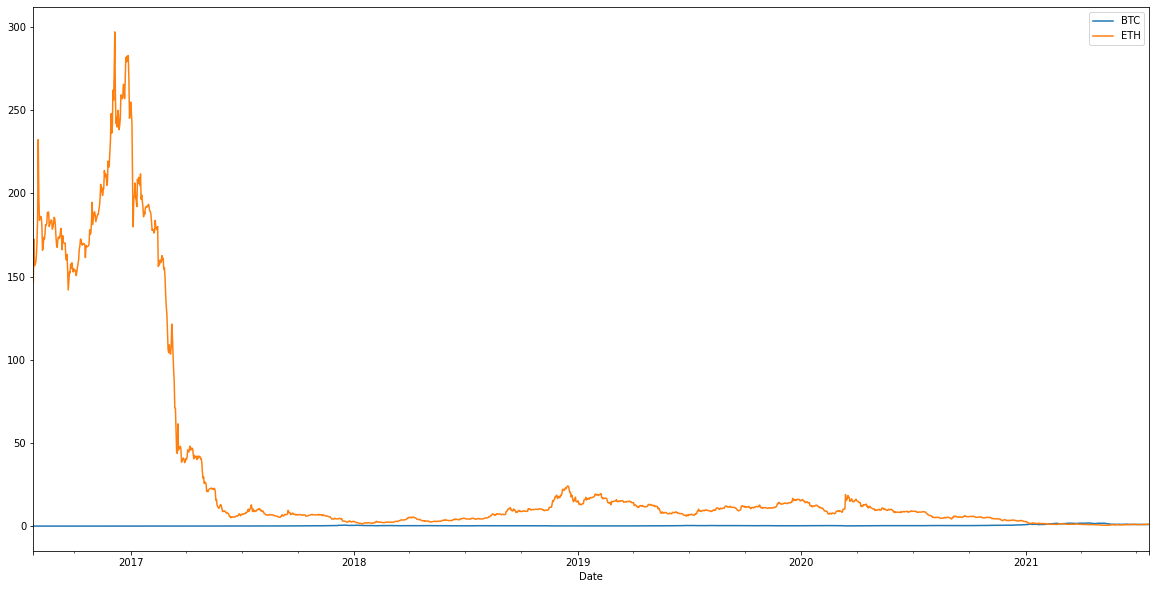

In [110]:
# Plot cumulative returns of btc compared to eth on monthly basis
df_cum = (1 + df_monthly_btc_eth).cumprod()
df_cum.plot(figsize = (20, 10))

<AxesSubplot:xlabel='Date'>

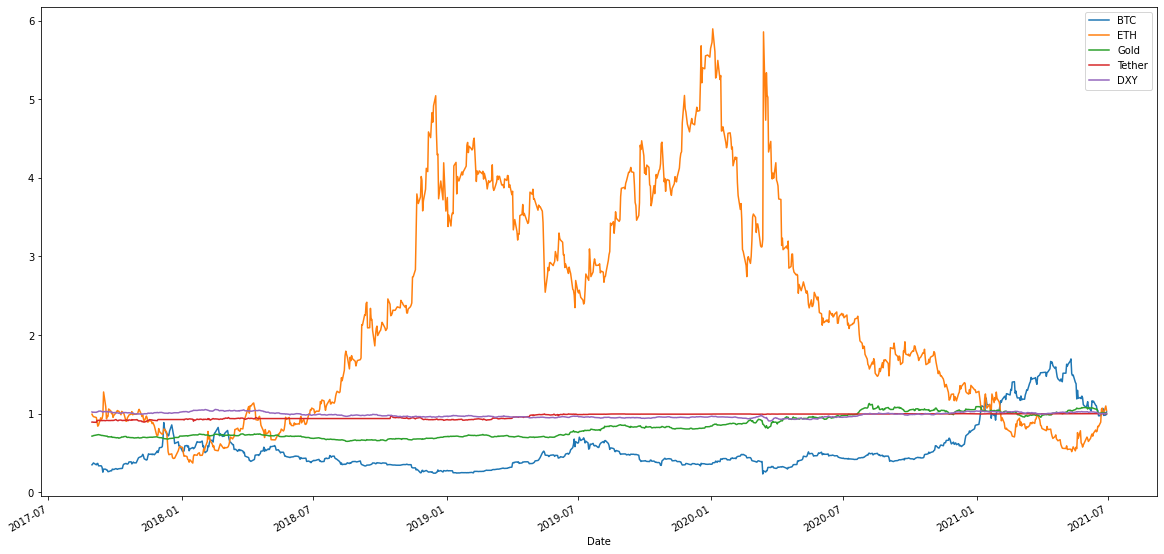

In [492]:
# Plot cumulative returns
df_cum = (1 + df_daily).cumprod()
df_cum.plot(figsize = (20, 10))

### Calculate Standard Deviations

In [493]:
# Calculate std for each asset
df_daily_std = pd.DataFrame(df_daily.std()).rename(columns = {0:"std"})
df_daily_std

,std
BTC,0.047066
ETH,0.056518
Gold,0.008917
Tether,0.003698
DXY,0.003697


In [494]:
# Determine which portfolio is more risky than dxy
higher_std = df_daily_std[df_daily_std["std"] > df_daily_std.loc["DXY", "std"]]
higher_std

,std
BTC,0.047066
ETH,0.056518
Gold,0.008917
Tether,0.003698


In [495]:
# Calculate annualized std
df_annualized_std = df_daily_std*np.sqrt(252)
df_annualized_std

,std
BTC,0.747151
ETH,0.897202
Gold,0.141550
Tether,0.058712
DXY,0.058692


<AxesSubplot:xlabel='Date'>

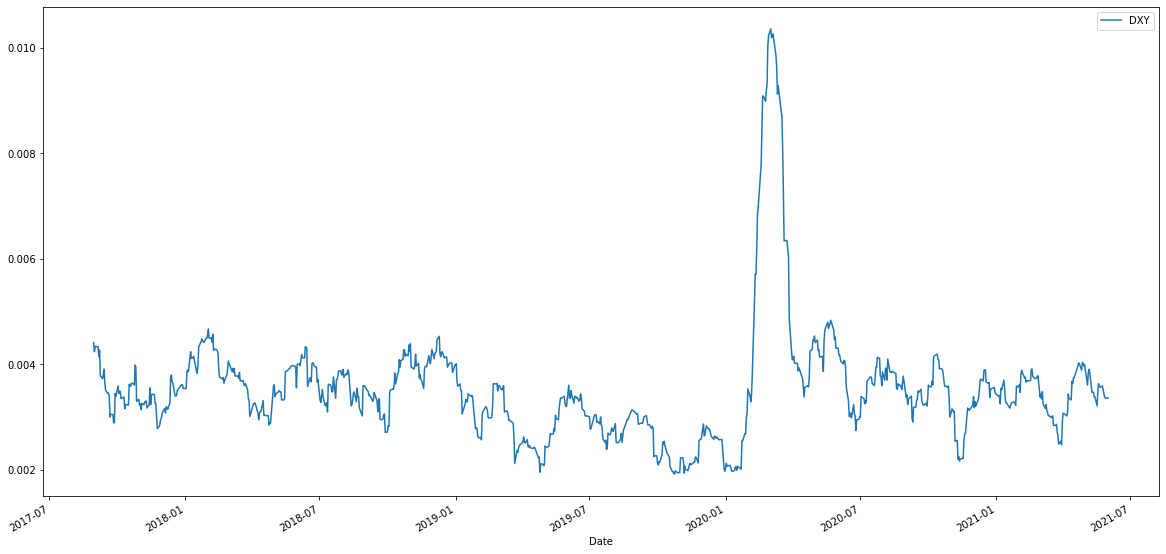

In [496]:
# Calculate and plot rolling std for dxy for 21 day period
dxy_rolling_21 = df_daily[["DXY"]].rolling(window=21).std()
dxy_rolling_21.plot(figsize = (20, 10))

### Calculate and plot the correlation

In [497]:
correlation_dxy = pd.DataFrame(df_daily.corr()).loc[:, "DXY"]
correlation_dxy [correlation_dxy==correlation_dxy[correlation_dxy<1].max()]

Gold    0.165731
Name: DXY, dtype: float64

<AxesSubplot:xlabel='DXY', ylabel='BTC'>

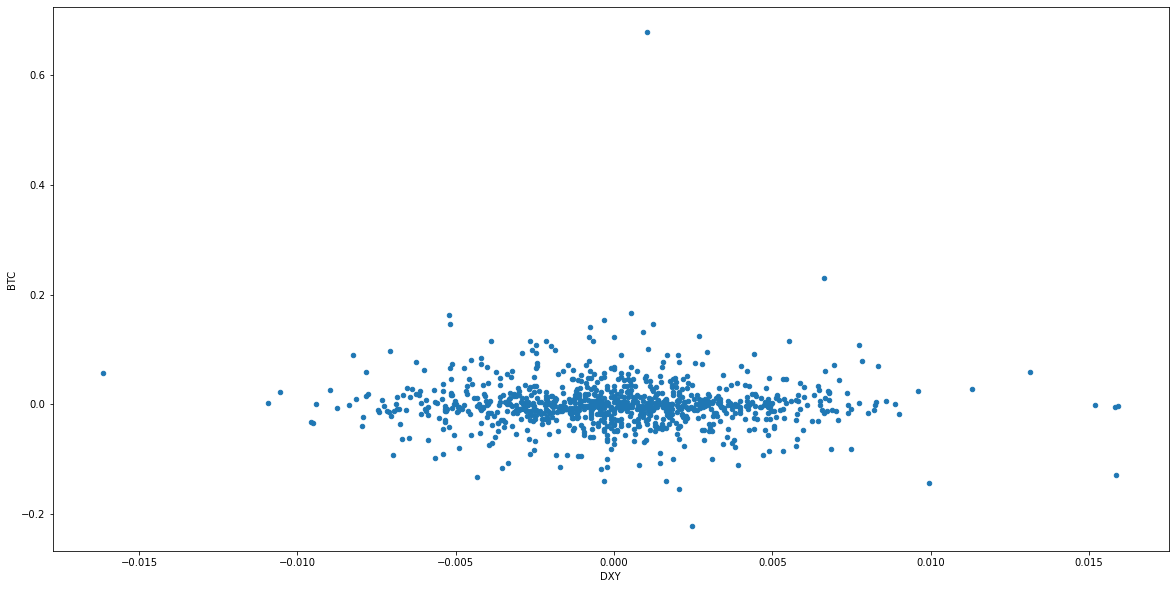

In [498]:
df_daily.plot(kind="scatter", y = "BTC", x = "DXY", figsize = (20, 10))

<AxesSubplot:xlabel='DXY', ylabel='ETH'>

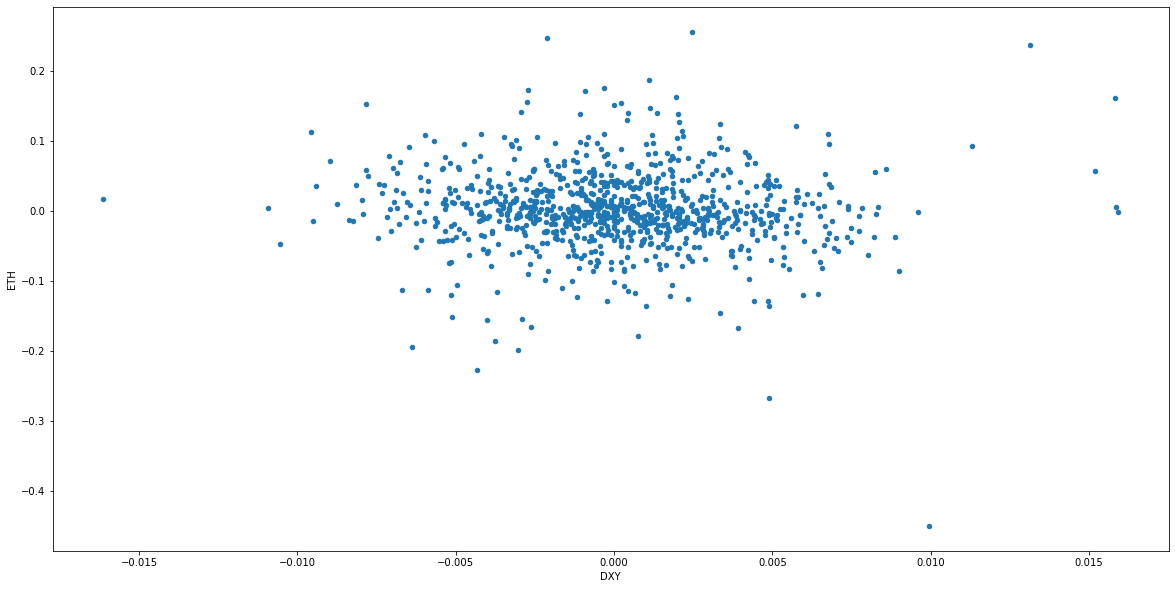

In [499]:
df_daily.plot(kind="scatter", y = "ETH", x = "DXY", figsize = (20, 10))

<AxesSubplot:xlabel='DXY', ylabel='Gold'>

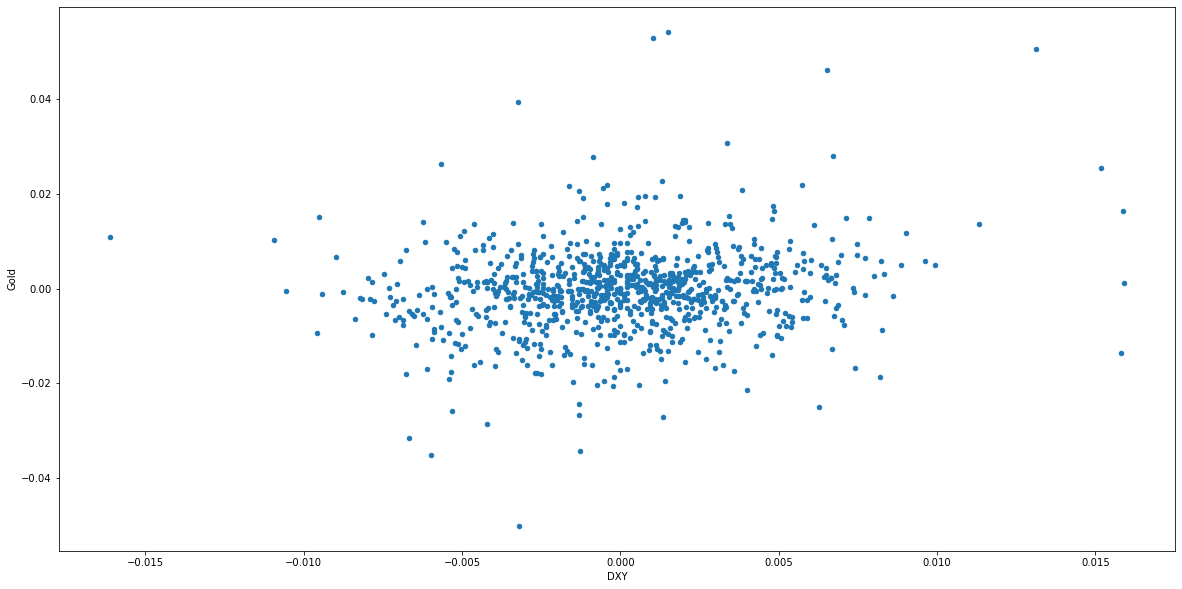

In [500]:
df_daily.plot(kind="scatter", y = "Gold", x = "DXY", figsize = (20, 10))

### Calculate and Plot Beta for a chosen chosen asset compared to DXY

<AxesSubplot:title={'center':'Rolling 60 day beta of Bitcoin comapred to DXY'}, xlabel='Date'>

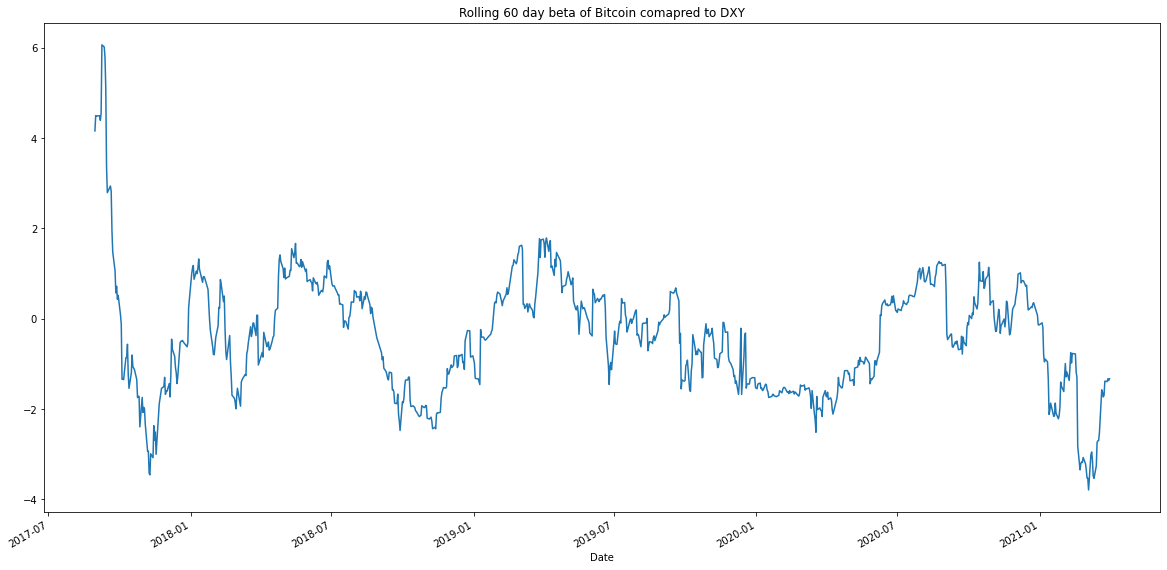

In [501]:
# Calculate Beta for bitcoin compared to dxy
rolling_covariance = df_daily['BTC'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title = 'Rolling 60 day beta of Bitcoin comapred to DXY')

<AxesSubplot:title={'center':'Rolling 60 day beta of Tether comapred to DXY'}, xlabel='Date'>

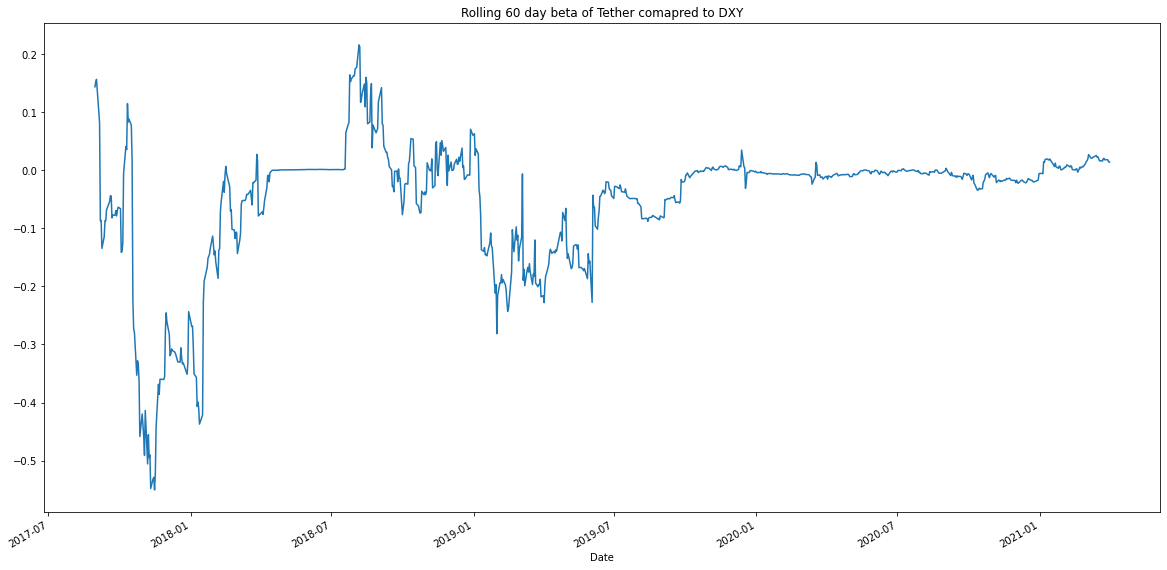

In [502]:
# Calculate Beta for tether compared to dxy
rolling_covariance = df_daily['Tether'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title = 'Rolling 60 day beta of Tether comapred to DXY')

<AxesSubplot:title={'center':'Rolling 60 day beta of ETH compared to DXY'}, xlabel='Date'>

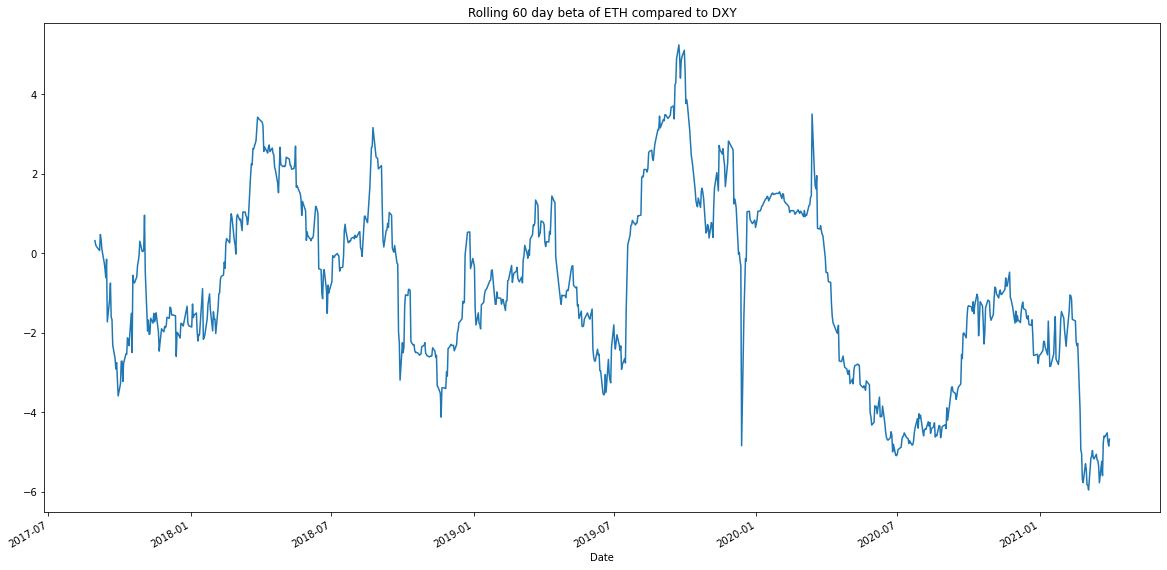

In [503]:
# Calculate Beta for eth compared to dxy
rolling_covariance = df_daily['ETH'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title = 'Rolling 60 day beta of ETH compared to DXY')

<AxesSubplot:title={'center':'Rolling 60 day beta of Gold comapred to DXY'}, xlabel='Date'>

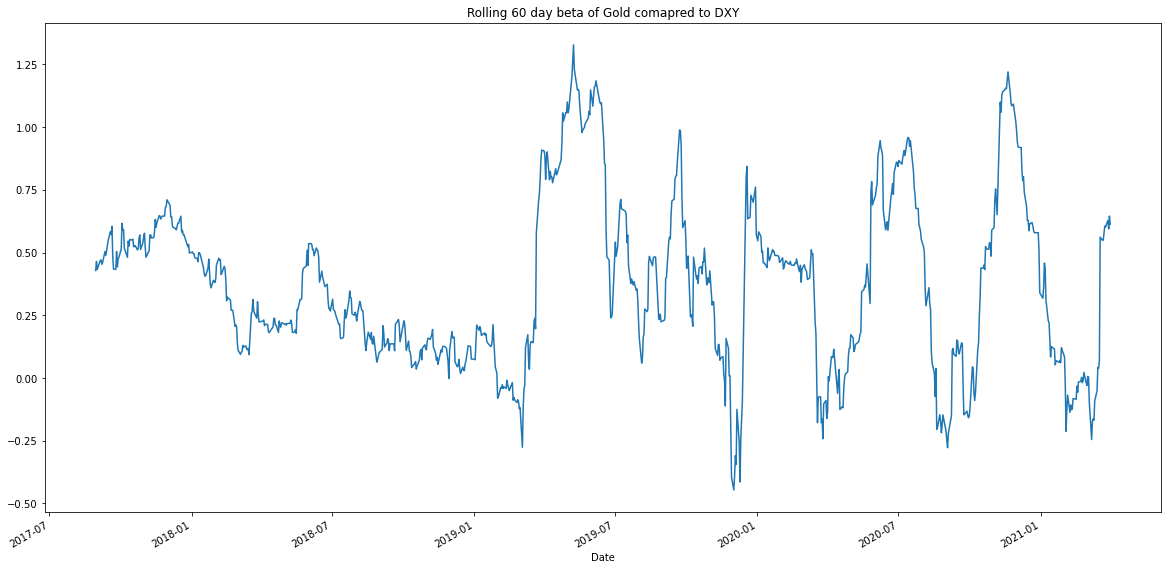

In [504]:
# Calculate Beta for gold compared to dxy
rolling_covariance = df_daily['Gold'].rolling(window=60).cov(df_daily['DXY'])
rolling_variance = df_daily['DXY'].rolling(window=60).var()
rolling_beta = rolling_covariance / rolling_variance
rolling_beta.plot(figsize=(20, 10), title = 'Rolling 60 day beta of Gold comapred to DXY')

In [505]:
#df_daily_gold_dxy_ewm = df_daily_gold_dxy.ewm(span = 21, adjust=False).mean()
#(1 + df_daily_gold_dxy_ewm).cumprod().plot(figsize=(20, 10))

#(1 + df_daily_gold_dxy_ewm).cumprod().hvplot(shared_axes)

<AxesSubplot:xlabel='Date'>

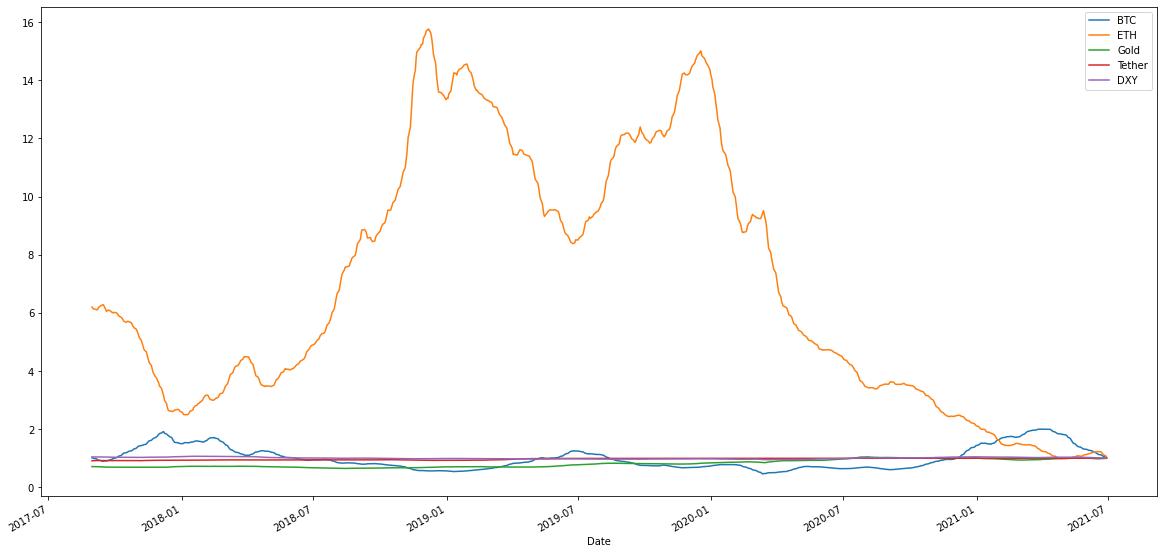

In [506]:
df_daily_ewm = df_daily.ewm(span = 21, adjust=False).mean()
(1 + df_daily_ewm).cumprod().plot(figsize=(20, 10))

# Sharpe Ratios
In reality, investment managers and institutional investors look at the ratio of return-to-risk, and not just the rate of return. When given the opportunity, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, which one would you take?

In [465]:
# Annualized sharpe ratios
sharpe_ratios = df_daily.mean()*252/(df_daily.std()*np.sqrt(252))
sharpe_ratios

BTC      -0.025898
ETH       0.461206
Gold     -0.561353
Tether   -0.485822
DXY       0.128609
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

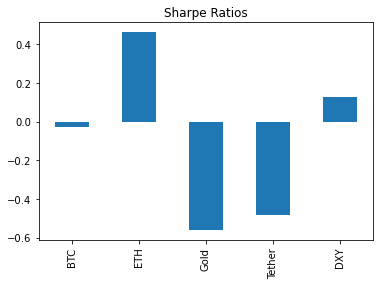

In [466]:
sharpe_ratios.plot(kind = "bar", title = "Sharpe Ratios")